In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [338]:
# Gets matrix of the respective linear system
# bc = 0 -> Dirichlet
# bc = 1 -> Neumann
def get_Matrix(h,bc):
    # n, the size of the matrix
    n = (int) (1.0/h - 1) +bc
    # creates zero matrix
    m = np.zeros((n,n))
    # Fills the matrix
    for i in range(n):
        for j in range(i-1,i+2):
            if (j >= 0) and (j < n):
                m[i,j] = integrate(get_int_Mat(i,j,h,int(1.0/(0.05*h))))
                m[j,i] = integrate(get_int_Mat(j,i,h,int(1.0/(0.05*h))))
    return m

# Gets the vector to integrate for matrix values
def get_int_Mat(i,j,h,m = 100) :
    x = np.linspace(0,1.01,m)
    return (sp1(x,j,h)+sp1_prime(x,j,h))*sp1(x,i,h) + sp1_prime(x,i,h)*sp1_prime(x,j,h)

# Gets vector of the respective linear system
# bc = 0 -> Dirichlet
# bc = 1 -> Neumann
def get_vec(h,bc):
    # n, the size of the matrix
    n = (int) (1.0/h - 1)+bc
    # creates zero matrix
    v = np.zeros(n)
    # Fills vector
    for i in range(n):
        # Position of vector v
        v[i] = integrate(get_int_free(i,h,int(1.0/(h*h))))
    return v

# Gets the vector to integrate for non homogeneous vector of the linear system
# bc = 0 -> Dirichlet
# bc = 1 -> Neumann
def get_int_free(i,h,m = 100) :
    # n, the size of the matrix
    n = (int) (1.0/h - 1)
    x = np.linspace(0,1,m)
    ans = ((x-1)*np.exp(x) - (x+1)*np.exp(1))*(sp1(x,i,h))
    # Neumann consideration
    if( i == n ):
        ans += np.exp(1)
    return ans

# Solves the linear system Mx = d for x
# General Gauss Jordan solver
# https://en.wikipedia.org/wiki/Tridiagonal_matrix_algorithm
# Works the same for dirichlet and neumann
def systemSolve(m,d):
    # n is the dimension of the system
    n = len(d)
    x = np.zeros(n)
    # Reduces matrix to row-echelon form
    for l in range(n-1):
        for j in range(l+1,n):
            const = (m[j,l]/m[l,l])
            #print(const,m[j,l],m[l,l])
            for i in range(l,n):
                #print("antes ", m[j,i],m[j,l])
                m[j,i] -= const*m[l,i]
                #print("desp ", m[j,i],m[j,l])
            d[j] -= const*d[l]
    #print(m,d)
    # Solves recursively for x
    x[n-1] = d[n-1]/m[n-1,n-1]
    for i in range(1,n):
        j = n-i-1
        for l in range(j,n):
            x[j] = (d[j]- np.dot(x[j+1:],m[j,j+1:]))/m[j,j]
    return x
    
# Integrates with trapezoid metho
# vector of values of the function is passed
def integrate(vals):
    dx = 0.5/(len(vals)+1)
    return dx*np.sum(vals[:-1]+vals[1:])

# Analytical solution
def analytical(x):
    return x*(np.exp(x)-e)

# Gets maximum error
# sol -> vector of splines
def get_Max_Err(sol,h):
    n = (int) (1.0/h - 1)
    xx = (np.array((range(n)))+1)*h
    # Differences vector
    diff = np.zeros(len(xx))
    for i in range(len(sol)):
        diff += sol[i]*sp1(xx,i,h)
    diff -= analytical(xx)
    diff = max(abs(diff))
    return diff  
        


In [339]:
# Defines splines of order 1 and index i
def sp1(x,i,h):
    # Having into account Neumann spline
    if( x >= 1):
        return 0
    # x transformation
    x = x/h -i-1
    # ans = 0 by default
    ans = 0
    if( (-1 >= x) and (x >= 1)):
        return 0
    if( (-1 <= x) and (x <= 0)):
        ans  = x+1
    elif( (0 <= x) and (x <= 1)):
        ans  = 1-x
    return ans

# Defines first derivative of splines of order 1 and index i
def sp1_prime(x,i,h):
    # Having into account Neumann spline
    if( x >= 1):
        return 0
    # x transformation
    x = x/h -i-1
    const = 1.0/h
    # ans = 0 by default
    ans = 0
    if( (-1 >= x) and (x >= 1)):
        return 0
    if( (-1 <= x) and (x <= 0)):
        ans  = const
    elif( (0 <= x) and (x <= 1)):
        ans  = -const
    return ans
    
# Vectorizes functions
sp1 = np.vectorize(sp1,otypes=[np.float32])
sp1_prime = np.vectorize(sp1_prime,otypes=[np.float32])

# Solution

In [340]:
hs = [0.2,0.1,0.05,0.01]
#xx = linspace(0,1,1000)
# the matrix
Dirichlet = []
Neumann = []
for h in hs:
    # The matrix
    M0 = get_Matrix(h,0)
    M1 = get_Matrix(h,1)
    # the vector
    d0 = get_vec(h,0)
    d1 = get_vec(h,1)
    # The solution
    sol0 = systemSolve(M0,d0)
    sol1 = systemSolve(M1,d1)
    # Fills arrays
    Dirichlet.append(get_Max_Err(sol0,h))
    Neumann.append(get_Max_Err(sol1,h))



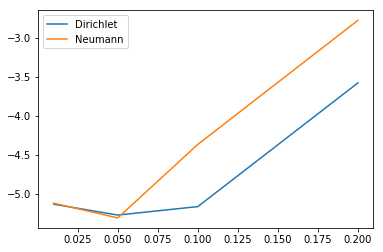

In [341]:
plot(hs,np.log(Dirichlet),label = "Dirichlet")
plot(hs,np.log(Neumann),label = "Neumann")
plt.legend()

In [327]:
def solution(x,sol,h):
    ans = np.zeros(len(x))
    for j in range(len(x)):
        for i in range(len(sol)):
            ans[j] += sol[i]*sp1(x[j],i,h)
        
    return ans


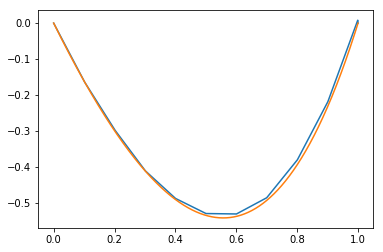

In [328]:
plot(xx,solution(xx,sol,h))
plot(xx,analytical(xx))

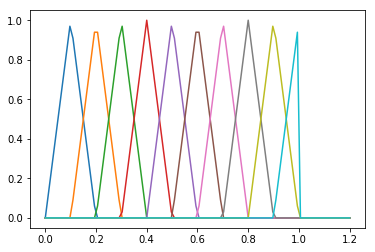

In [308]:
h = 0.1
xx = linspace(0,1.2,100)
for i in range(n+1):
    plot(xx,sp1(xx,i,h))

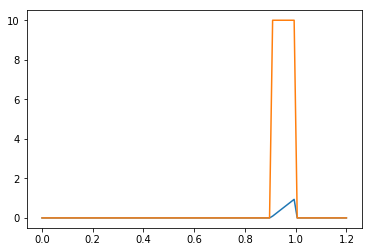

In [313]:
plot(xx,sp1(xx,n,h))
plot(xx,sp1_prime(xx,n,h))

In [344]:
integrate(sin(linspace(0,np.pi,10000)))

0.63649245590824233